In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import random

# from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from collections import Counter

random.seed(7)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/bankdefaultsinrussia/dataset.csv


# I. Classic ML
*Prediciton of banks' default and its probability*

Goals:
- to analyze how well we can predict default and its probability with classic ML methods
- to use predicted features as part of larger Language Model

## 1. Russian banks' defaults Dataset 

In [2]:
df = pd.read_csv('/kaggle/input/bankdefaultsinrussia/dataset.csv')
df = df.dropna().reset_index(drop=True)

df['дата'] = pd.to_datetime(df['дата'])

df = df.astype({'лицензия': 'int', 'default': 'int', 'msk_spb': 'int'})
#        .astype({'лицензия': 'object', 'default': 'object', 'msk_spb': 'object'})

df = df.rename(columns={'лицензия': 'licence_num', 'дата': 'date'})  # .drop(columns=['дата'])

In [3]:
# feature engineering
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = pd.DatetimeIndex(df['date']).dayofweek
df['yearmonth'] = df.apply(lambda row: 100 * row['year'] + row['month'], axis = 1)

df['n_reports'] = df.groupby('licence_num')['licence_num'].transform('count')
df['occurence'] = df.groupby(['licence_num']).cumcount()+1

In [4]:
df.head()

,licence_num,date,net_assets,ROA,liquid,ibl,stocks,bond,oth_cap,sunk_retail_credit,...,i_retail_spread_diff,usd_rub_return,miacr_diff,default,month,year,day_of_week,yearmonth,n_reports,occurence
0,0,2010-02-01,423017.0,27.0,112770.0,60000.0,0.0,0.0,0.0,0.0,...,0.0,0.008065,-0.830116,0,2,2010,0,201002,21,1
1,0,2010-03-01,498411.0,75.0,172628.0,90000.0,0.0,0.0,0.0,0.0,...,-0.1,0.010699,-0.172562,0,3,2010,0,201003,21,2
2,0,2010-04-01,571220.0,54.0,211860.0,90000.0,0.0,0.0,0.0,997.0,...,0.1,-0.019848,-0.296650,0,4,2010,3,201004,21,3
3,0,2010-05-01,523027.0,41.0,159970.0,90000.0,0.0,0.0,0.0,481.0,...,-0.1,-0.012387,-0.255000,0,5,2010,5,201005,21,4
4,0,2010-06-01,473713.0,31.0,131782.0,135000.0,0.0,0.0,0.0,485.0,...,0.1,0.042533,-0.533087,0,6,2010,1,201006,21,5


## 2. EDA

In [5]:
print('total number of observations: ', len(df))
print('total number of banks: ', len(df.licence_num.unique()))
print('total number of default cases: ', df.default[df.default == 1].count())

total number of observations:  70483
total number of banks:  1006
total number of default cases:  373


In [6]:
df.describe(include='all')

,licence_num,date,net_assets,ROA,liquid,ibl,stocks,bond,oth_cap,sunk_retail_credit,...,i_retail_spread_diff,usd_rub_return,miacr_diff,default,month,year,day_of_week,yearmonth,n_reports,occurence
count,70483.000000,70483,7.048300e+04,70483.000000,7.048300e+04,7.048300e+04,7.048300e+04,7.048300e+04,7.048300e+04,7.048300e+04,...,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000,70483.000000
mean,2127.323241,2013-10-22 01:31:26.803910400,7.236481e+07,122.509414,5.012372e+06,7.697896e+06,6.666620e+05,8.128531e+06,1.789404e+06,6.694933e+05,...,-0.034402,0.009303,0.080183,0.005292,6.511655,2013.348737,3.028049,201341.385313,79.551736,40.275868
min,0.000000,2010-02-01 00:00:00,0.000000e+00,-64556.000000,0.000000e+00,0.000000e+00,-1.223600e+04,0.000000e+00,0.000000e+00,0.000000e+00,...,-25.940000,-0.118357,-1.848351,0.000000,1.000000,2010.000000,0.000000,201002.000000,1.000000,1.000000
25%,1222.000000,2012-01-01 00:00:00,1.288528e+06,14.000000,1.880120e+05,1.587500e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.730000e+02,...,-0.580000,-0.015871,-0.213459,0.000000,3.000000,2012.000000,1.000000,201201.000000,71.000000,19.000000
50%,2388.000000,2013-09-01 00:00:00,3.634798e+06,91.000000,4.904740e+05,1.770360e+05,0.000000e+00,6.046600e+04,0.000000e+00,8.633000e+03,...,-0.100000,-0.001414,0.021180,0.000000,6.000000,2013.000000,3.000000,201309.000000,87.000000,38.000000
75%,3013.000000,2015-07-01 00:00:00,1.363160e+07,214.000000,1.467784e+06,8.002580e+05,1.601100e+04,1.099926e+06,6.800000e+01,5.926050e+04,...,0.300000,0.026706,0.193273,0.000000,10.000000,2015.000000,5.000000,201507.000000,94.000000,60.000000
max,3481.000000,2017-12-01 00:00:00,2.377734e+10,76314.000000,1.814549e+09,2.058386e+09,2.559021e+08,2.453111e+09,9.821342e+08,1.770647e+08,...,16.750000,0.206696,5.257585,1.000000,12.000000,2017.000000,6.000000,201712.000000,95.000000,95.000000
std,1024.225345,NaN,7.128239e+08,932.385773,4.456060e+07,6.603335e+07,5.726575e+06,7.491471e+07,2.863922e+07,5.535170e+06,...,4.092392,0.049228,0.817419,0.072554,3.457549,2.126181,2.003309,212.431594,17.871872,25.174696


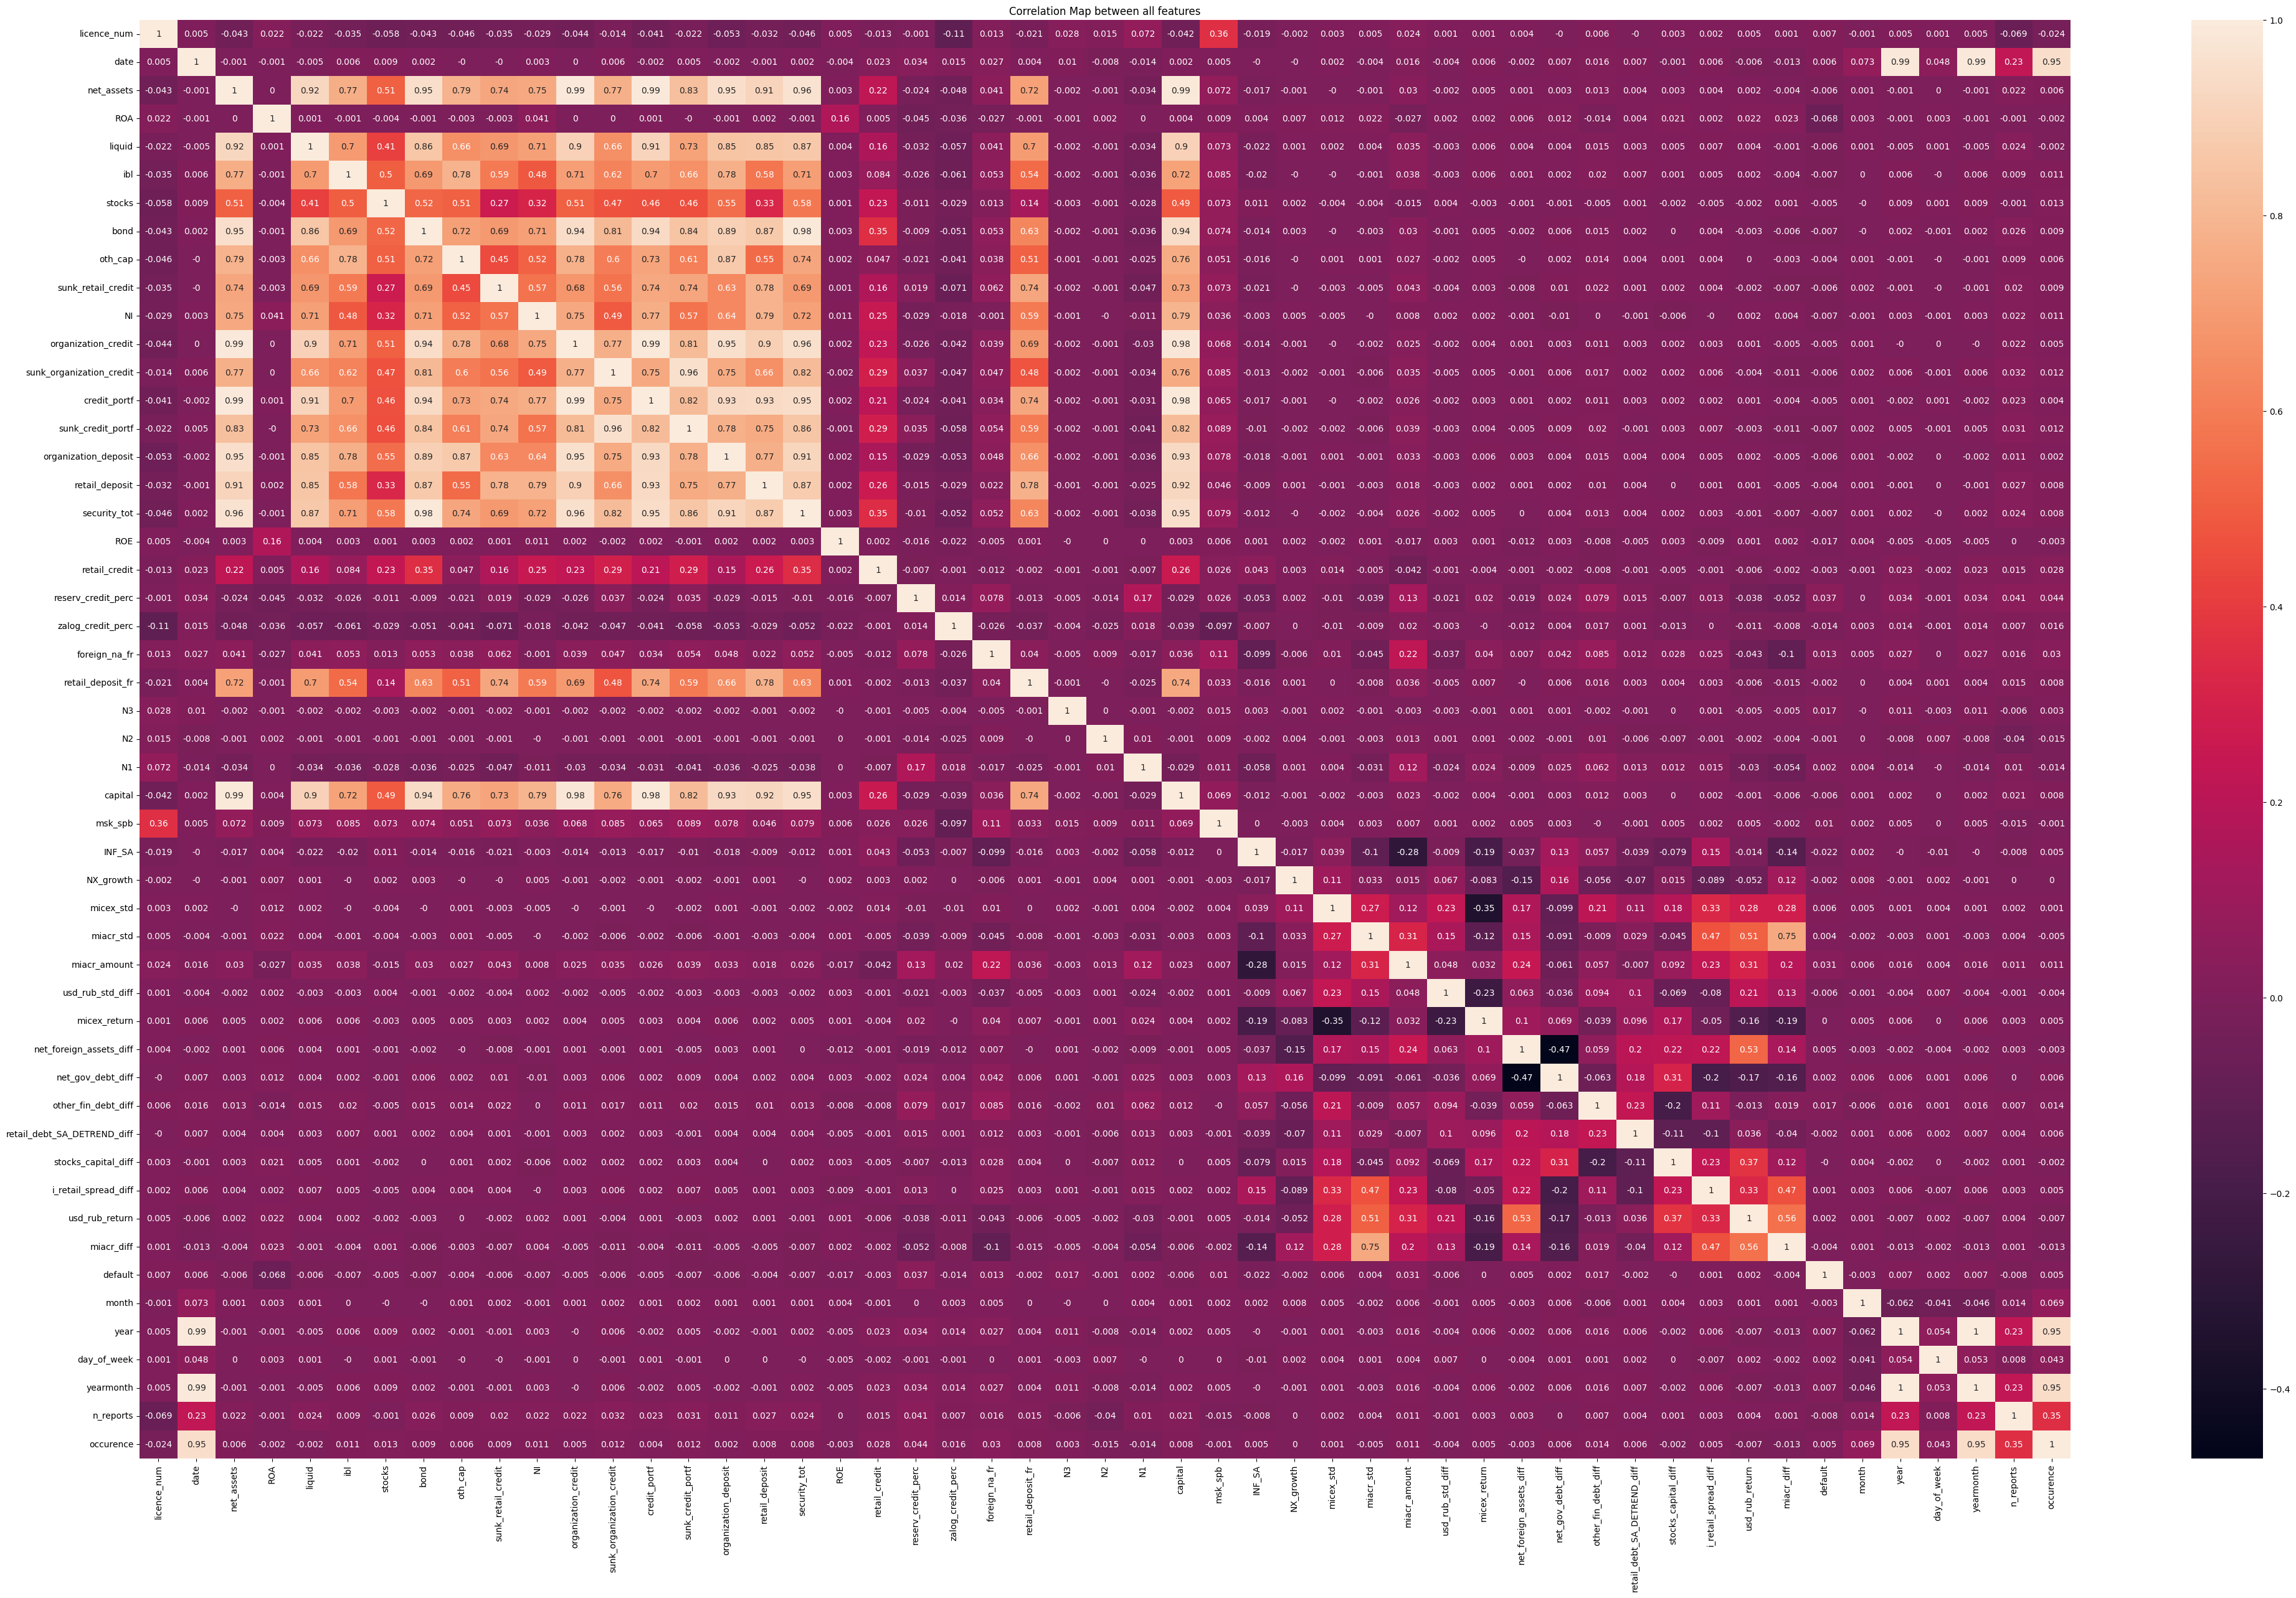

In [7]:
corr_matrix = df.corr().round(3)

fig, ax = plt.subplots(figsize=(50,30))
ax = sns.heatmap(corr_matrix, annot=True).set(title='Correlation Map between all features')

plt.savefig("seaborn_plot.png")

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [9]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [10]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

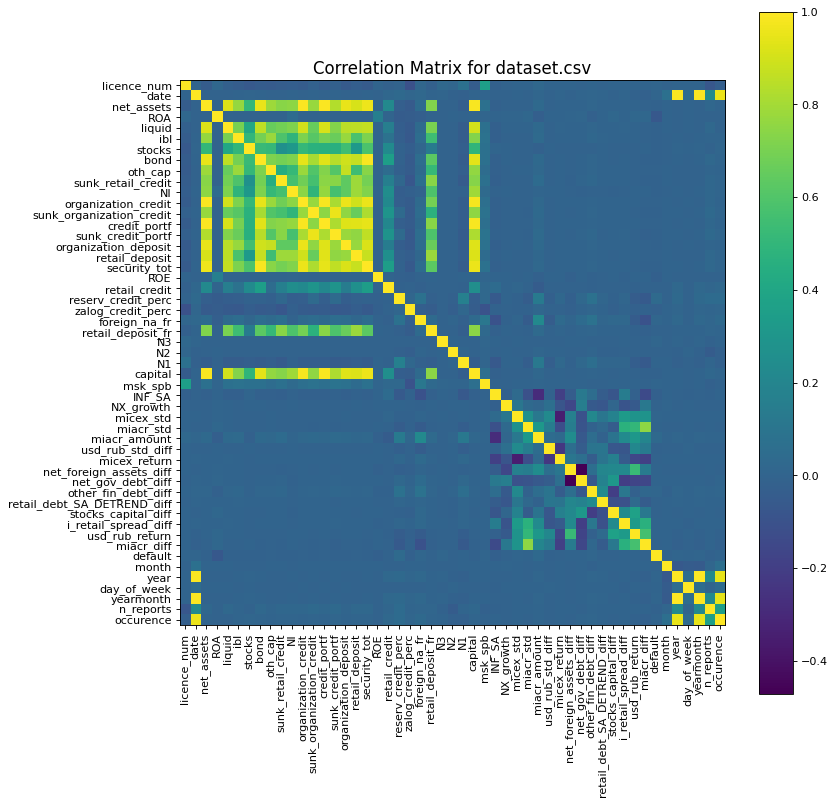

In [11]:
plotCorrelationMatrix(df, 11)

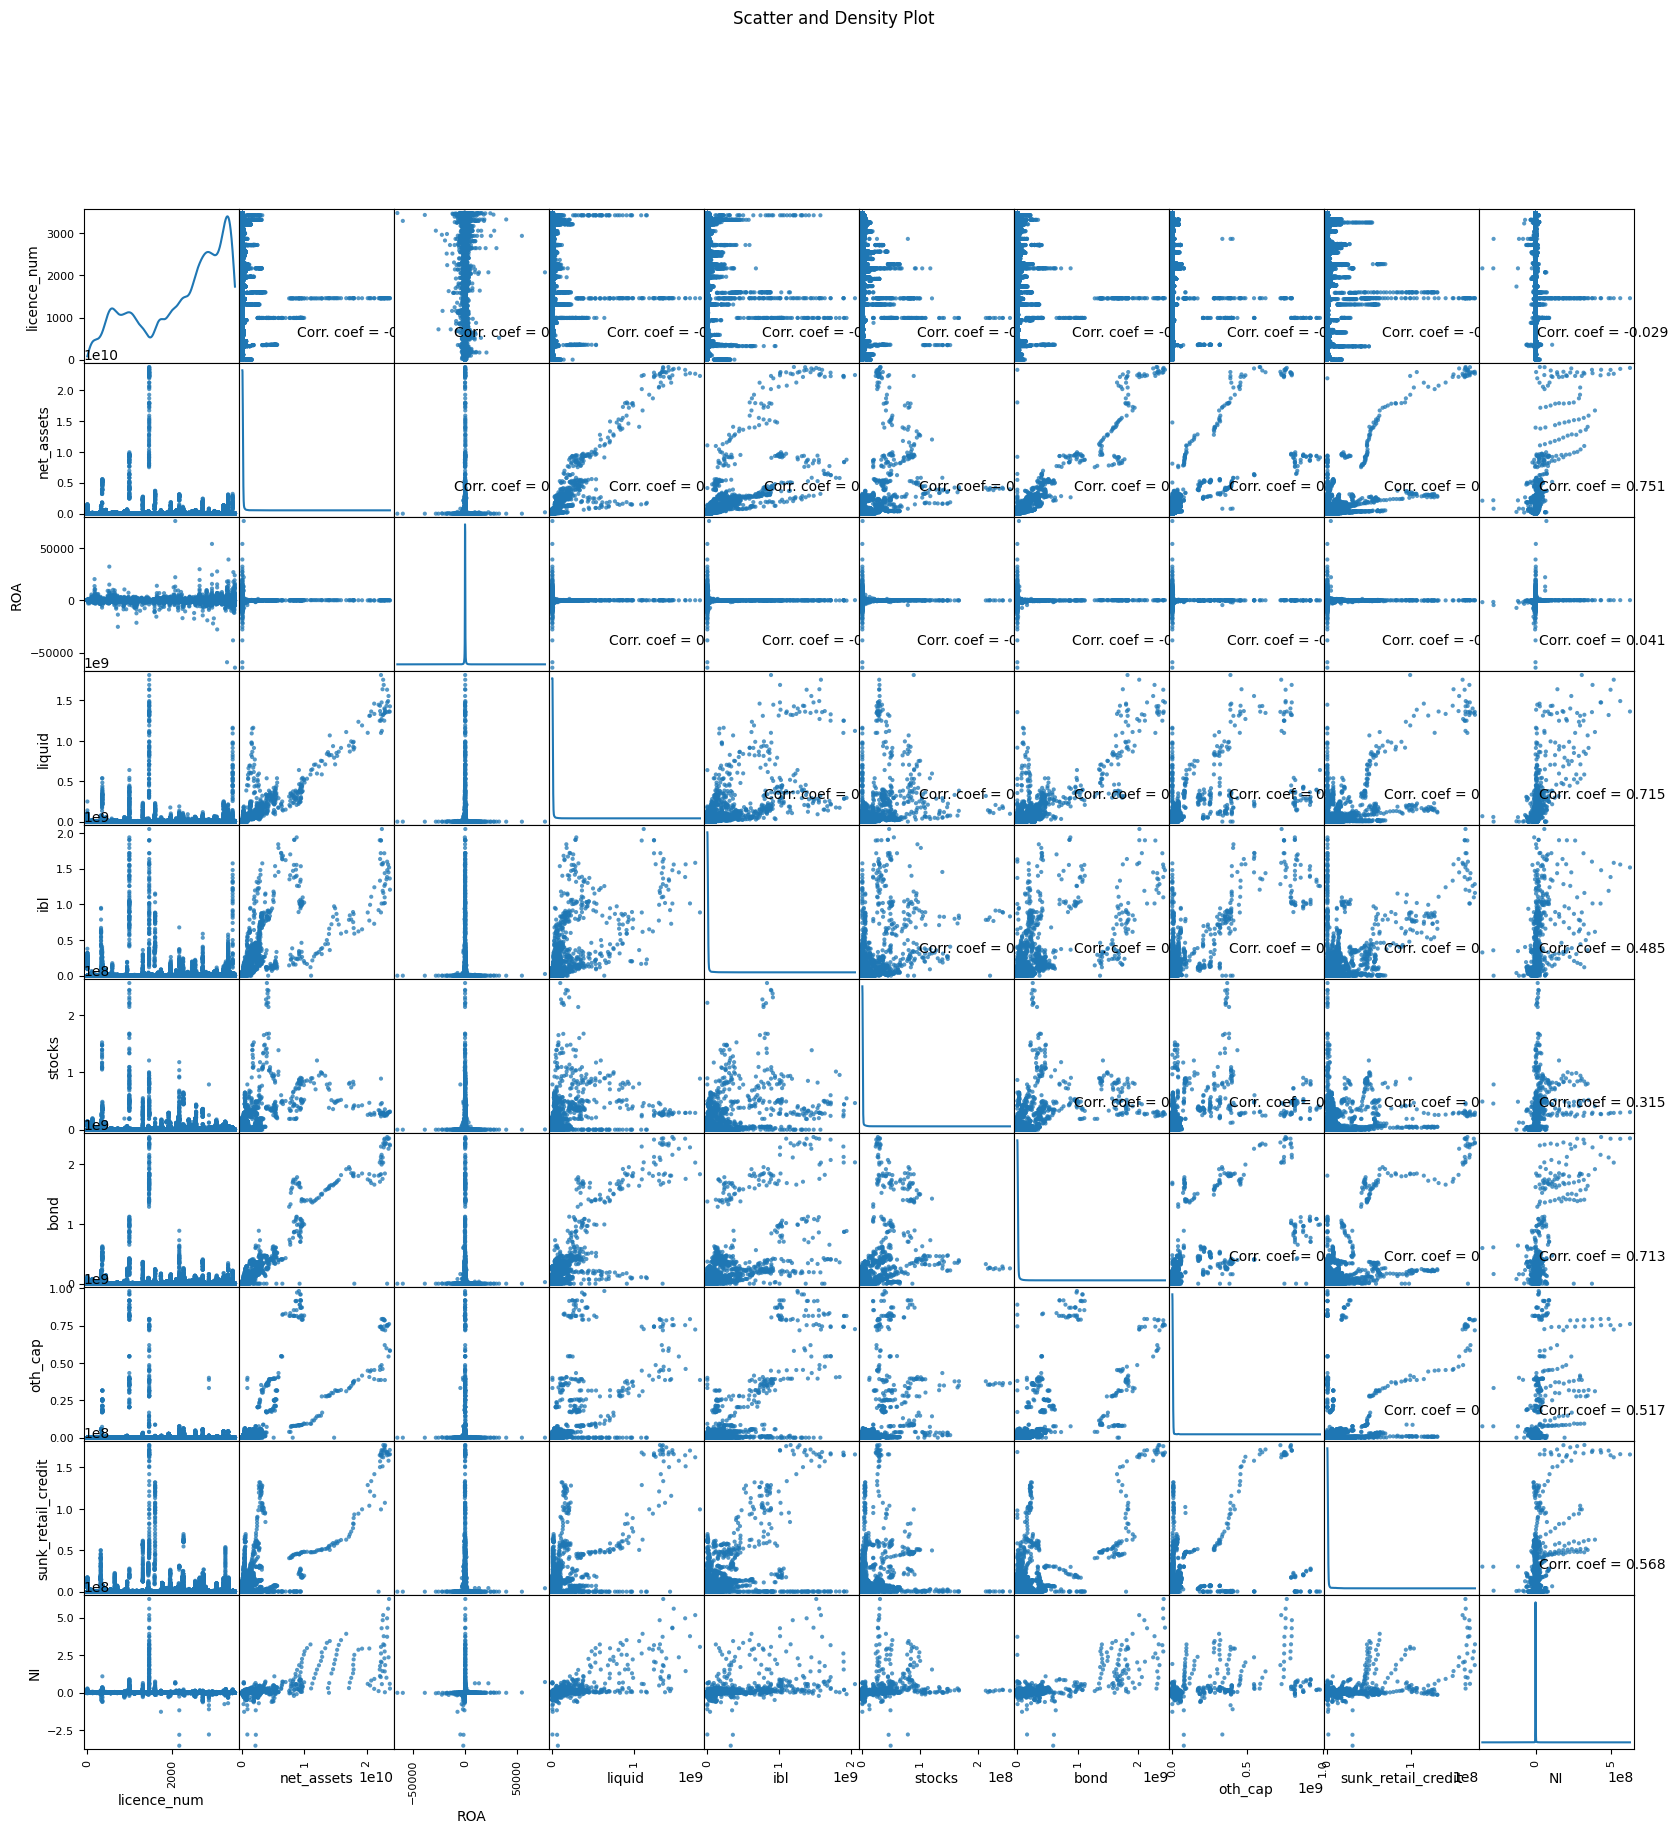

In [12]:
plotScatterMatrix(df, 20, 10)

*Conclusions*
* There is a panel data in the Dataset. So we can predict defaults in 2 ways:
    * For every period *(a)*
    * For every bank based on aggregated data *(b)*
* Moreover, we can try to solve 2 types of ML problems:
    * Binary classification of the event of Default
    * Regression model that predicts Probability of Default (e.g. based on Credit Ratings Data - *to be added*)
* Strong correlation between features based on financial statement due to the same types of indicators used for its calculation
* Might be Small Data Issue
* There is a need to balance classes for prediction, especially for task *(a)*

## 3. Default Prediction Models for every period

In [13]:
def get_scores(_yhat: np.array, _y_true: np.array, task='classification'):

    """
    Costumizes the confusion matrix,
    and calculates recall and precision for both classes.
    """
    _bmx = confusion_matrix(_yhat, _y_true).flatten()

    _OO = _bmx[0]
    _OI = _bmx[2]
    _IO = _bmx[1]
    _II = _bmx[3]

    # FOR CLASS 1
    _per1 = _II / (_II + _OI)
    _rec1 = _II / (_II + _IO)

    # FOR CLASS 0
    _per0 = _OO / (_OO + _IO)
    _rec0 = _OO / (_OO + _OI)

    # F1 SCORES
    _f11 = 2 * _per1 * _rec1 / (_per1 + _rec1)
    _f10 = 2 * _per0 * _rec0 / (_per0 + _rec0)

    # F1 TOTAL
    _ftot = 2 * _f11 * _f10 / (_f11 + _f10)

    _cc = Counter(_y_true.flatten())
    _res = {"PREC_DEFAULT": _per1,
            "REC_DEFAULT": _rec1,
            "PRE_NOT_DEFAULT": _per0,
            "REC_NOT_DEFAULT": _rec0,
            "F1_DEFAULT": _f11,
            "F1_NOT_DEFAULT": _f10,
            "F1_ALL": _ftot,
            "NOT_DEFAULT": _cc[0],
            "DEFAULT": _cc[1],
            "NOT_as_NOT": _OO,
            "NOT_as_CLS": _OI,
            "CLS_as_NOT": _IO,
            "CLS_as_CLS": _II,
            "BENCHMARK PRECISION FOR DEFAULT": (_II+_IO)/sum(_cc.values())}
    
    if task == 'classification':
        _res['ACCURACY'] = accuracy_score(_yhat, _y_true)
        
    return _res

In [39]:
target_feature = 'default'
exclude_features = ['licence_num', 'date', target_feature]
model_features = np.setdiff1d(df.columns.to_numpy(), np.array(exclude_features))

cat_features = ['day_of_week', 'month', 'year', 'yearmonth', 'msk_spb']
numeric_features = np.setdiff1d(df.columns.to_numpy(), np.array([*exclude_features, *cat_features]))

y = df[target_feature]
X = df[model_features]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9, stratify=y)
test_samples = random.sample(list(y[y == 1].index), 10)

In [40]:
from catboost import CatBoostClassifier

model0 = CatBoostClassifier(random_seed=7, verbose=0)

pipe = Pipeline([
    ('preprocessing_', ColumnTransformer([
        ('num_preproc', StandardScaler(), numeric_features),
        ('cat_preproc', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features)
    ])),
    ('model_', model0)
])

pipe.fit(X, y)
y_pred = pipe.predict(X.iloc[test_samples])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
print('accuracy: ', accuracy_score(y_pred, [1] * 10))

accuracy:  0.6


In [42]:
pd.DataFrame([
    get_scores(np.array(y_pred), np.array([1] * 10)), 
#     get_scores(rft.predict(X_test), y_test.values),
], index = ['BASE PARAMS RF']).T

/tmp/ipykernel_33/988569002.py:20: RuntimeWarning: invalid value encountered in scalar divide
  _rec0 = _OO / (_OO + _OI)


,BASE PARAMS RF
PREC_DEFAULT,1.00
REC_DEFAULT,0.60
PRE_NOT_DEFAULT,0.00
REC_NOT_DEFAULT,NaN
F1_DEFAULT,0.75
F1_NOT_DEFAULT,NaN
F1_ALL,NaN
NOT_DEFAULT,0.00
DEFAULT,10.00
NOT_as_NOT,0.00


*Comment:* 

*For experiment I didn't split dataset on test and train due to strong target classes disbalance.*

*So, I just took 10 observations of Default and checked how well wooden model learned to detect default case from so many non-default observations.*



In [ ]:
# transformation to Regression task - to be added...

*Conclusion:*

- To simpify this part I just stopped at CatBoost model that has quite good quality. It can identify 6/10 default cases for our test sample. Of course, quality and metrics can be improved and they will. 
- *Plan: make a little improvement of this model and work more with features and model configuration*

...


## 4. Default Prediction Models for every bank

In [ ]:
# transformation to Default Classification task for every bank - to be added...

In [ ]:
# transformation to Regression task - to be added...

# II. DL

*Prediciton of news influence on bank return and risk indicators*

Goals:
- to analyze news data, combine different sources of information
- initially, to distinguish financial/economic news data from other types; later, to parse more these types of news
- to identify metrics how to evaluate model quality
- to experiment with LLM models
- to add predicted default by ML model as features for DL model + possibly, add other features used for learning in Part I  

## 1. News Datasets

## 2. EDA

# 3. Models